In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 38 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
# Import the required libraraies
import cv2
import tensorflow as tf
import numpy as np 
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import fashion_mnist, cifar10
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy import misc
%matplotlib inline

In [4]:
#cifar class map
'''
cifar_class_map = {0:'airplane',
                   1:'automobile',
                   2:'bird',
                   3:'cat',
                   4:'deer',
                   5:'dog',
                   6:'frog',
                   7:'horse',
                   8:'ship',
                   9:'truck'}
'''
fashion_mnist_class_map = {0:'t shirt',
                           1:'trouser',
                           2:'pullover',
                           3:'dress',
                           4:'coat',
                           5:'sandal',
                           6:'shirt',
                           7:'sneaker',
                           8:'bag', 
                           9:'ankle boot'}

4423680/4422102 [==============================] - 0s 0us/step
(1, 32, 32)
(1, 32, 32, 1)
sandal


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


Text(0.5, 1.0, 'sandal')

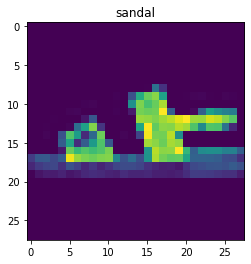

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

idx = np.random.randint(0, x_test.shape[0])
img = x_test[idx] 

img = np.array([misc.imresize(img, (32, 32)).astype(float)])  # fashion mnist

img = img/255 

print(img.shape)

img = img[:, :, :, np.newaxis]  # fashion mnist

#img = img[np.newaxis, :, :, :]  # cifar10

print(img.shape) 

plt.imshow(x_test[idx])
print(fashion_mnist_class_map.get(int(y_test[idx])))  # fashion mnist
#print(cifar_class_map.get(int(y_test[idx]))) # cifar10
plt.title(fashion_mnist_class_map.get(int(y_test[idx])))  # fashion mnist
# plt.title(cifar_class_map.get(int(y_test[idx])))  # cifar10

In [6]:
model = load_model('/content/gdrive/MyDrive/MasterThesis/fashionMNIST_ResNet20_model.068.h5')
pred = model(img)

print(np.argmax(pred))
print(fashion_mnist_class_map.get(np.argmax(pred))) # fashion mnist
# print(cifar_class_map.get(np.argmax(pred))) #cifar10

5
sandal


In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
'''create a model till  last convolutional layers to have the best compromise between high-level semantics and detailed spatial
information'''

LAYER_NAME = 'conv2d_20'
gb_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.get_layer(LAYER_NAME).output])
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer, 'activation')]


In [9]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [10]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [11]:
with tf.GradientTape() as tape:
 inputs = tf.cast(img, tf.float32)
 tape.watch(inputs)
 outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]

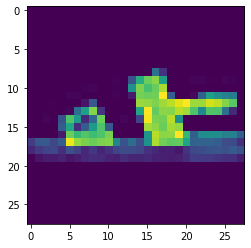

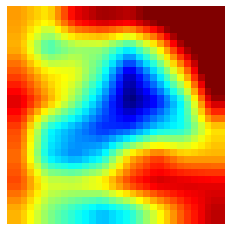

In [12]:
#GRAD CAM 

weights = tf.reduce_mean(grads, axis=(0, 1))
grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    grad_cam += w * outputs[:, :, i]
    
grad_cam_img = cv2.resize(grad_cam.numpy(), (32, 32))

img = img.squeeze(axis=0)

grad_cam_img = np.maximum(grad_cam_img, 0)
heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)

plt.imshow(x_test[idx])
plt.show()
plt.imshow(output_image)
plt.axis("off");
plt.show()

(32, 32, 1)


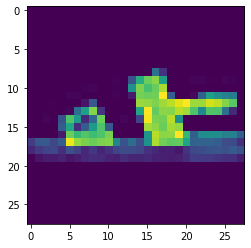

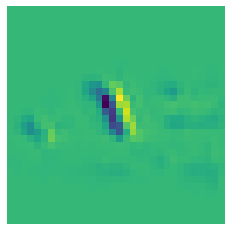

In [13]:
#GUIDED BACKPROPAGATION
guided_back_prop =grads
print(grads.shape)
gb_viz = np.dstack((
            guided_back_prop[:, :, 0],
            #guided_back_prop[:, :, 1],    # uncomment for cifar10
            #guided_back_prop[:, :, 2],    # uncomment for cifar10
        ))       

gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()
    
plt.imshow(x_test[idx])
plt.show()
imgplot = plt.imshow(gb_viz.squeeze())
plt.axis("off")
plt.show()

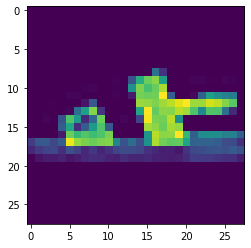

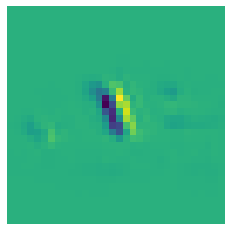

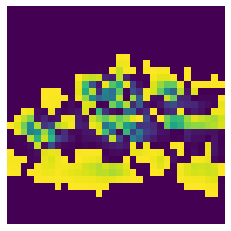

In [14]:
# GUIDED GRADCAM 
guided_cam = np.maximum(grad_cam, 0)
guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
guided_cam = resize(guided_cam, (32,32), preserve_range=True)
#pointwise multiplcation of guided backprop and grad CAM 
gd_gb = np.dstack((
        guided_back_prop[:, :, 0] * guided_cam,
        #guided_back_prop[:, :, 1] * guided_cam, # uncomment for cifar10
        #guided_back_prop[:, :, 2] * guided_cam, # uncomment for cifar10
    ))

plt.imshow(x_test[idx])
plt.show()

gd_gb = gd_gb.squeeze(axis=-1)

imgplot = plt.imshow(gd_gb)
plt.axis("off")
plt.show()

imgplot = plt.imshow(gd_gb.astype(np.uint8))
plt.axis("off")
plt.show()


#imgplot = plt.imshow(gd_gb.squeeze(axis=-1))
#plt.axis("off")
#plt.show()

In [15]:
# Reference 
# https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
# https://matplotlib.org/stable/tutorials/colors/colormaps.html